In [36]:
#scientific libraries and plotting
import numpy as np
import scipy as scipy
from scipy import stats
from scipy.optimize import minimize
from scipy import signal
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import awkward as ak
from tqdm import tqdm

#torch specific
import torch
import torchvision as torchv
import torch.optim as optim

#other libraries
import time
import sys
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import atlas_mpl_style as ampl
#Using newest versions of all libraries

In [37]:
# import custom functions from src folder
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from machine_learning import *
from resnet import *
from imcal import *

from resnet import ResNet18

In [38]:
#variables controlled by the user. Change these to fit your specific needs.
RES = 50 #resolution
LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "BH_n4_M8", "BH_n2_M10", "BH_n4_M10", "BH_n6_M10", "BH_n4_M12"]
TEST_LABELS = [f"{label}_test" for label in LABELS]
PLOT_LABELS = ["SPH_9", "BH_n4_M8", "BH_n2_M10", "BH_n4_M10", "BH_n6_M10", "BH_n4_M12"]
CLASSES = len(LABELS) #The number of output nodes in the net, equal to the number of classes
FOLDERS = ["sph", "BH", "BH", "BH", "BH", "BH"]
TEST_N_EVENTS = 15000
CUT = True
LOAD = False
N_max = 35 #Maximum number of events measured
M = 3000 #Number of experiments to average

#Set data paths
if CUT:
    N_EVENTS = 15000
    TEST_FILENAMES = [f"{label}_res{RES}_STmin7_Nmin5_15000_events.h5" for label in TEST_LABELS]
else:
    N_EVENTS = 3000
    TEST_FILENAMES = [f"{label}_res{RES}_3000_events.h5" for label in TEST_LABELS]
TEST_DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{FOLDERS[i]}/{RES}/{TEST_FILENAMES[i]}" for i in range(CLASSES)]

MODEL_NAME = "resnet_1696929580_SPH_9_BH_n4_M8_BH_n2_M10_BH_n4_M10_BH_n6_M10_BH_n4_M12_CUT_res50"
LOAD_FOLDER = "../results/models"
LOAD_PATH = f"{LOAD_FOLDER}/{MODEL_NAME}.pt"


DEVICE = torch.device("cpu")
print("Running on the CPU")

ampl.use_atlas_style()   
paper_colors = sn.color_palette("deep", n_colors = len(LABELS))
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

Running on the CPU


In [39]:
print(paper_colors.as_hex())
paper_colors = ['#4c72b0','#55a868', '#dd8452', '#c44e52',  '#937860', '#8172b3']


['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3', '#937860']


In [40]:
#import model
model = ResNet18(img_channels=3, num_classes=CLASSES)
model.load_state_dict(torch.load(LOAD_PATH))
model.eval()
model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), padding_mode=circular)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding_mode=circular)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding_mode=circular)
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 64, kernel_siz

In [41]:
#Load data
sph_testpath = [Path(TEST_DATAPATHS[0])]
sph_test_data = Hdf5Dataset(sph_testpath, TEST_LABELS, DEVICE, 
                        shuffle=False, filters=[None], transform=None, event_limit=TEST_N_EVENTS)

bh_1_testpath = [Path(TEST_DATAPATHS[1])]
bh_1_test_data = Hdf5Dataset(bh_1_testpath, TEST_LABELS, DEVICE, 
                        shuffle=False, filters=[None], transform=None, event_limit=TEST_N_EVENTS)

bh_2_testpath = [Path(TEST_DATAPATHS[2])]
bh_2_test_data = Hdf5Dataset(bh_2_testpath, TEST_LABELS, DEVICE, 
                        shuffle=False, filters=[None], transform=None, event_limit=TEST_N_EVENTS)

bh_3_testpath = [Path(TEST_DATAPATHS[3])]
bh_3_test_data = Hdf5Dataset(bh_3_testpath, TEST_LABELS, DEVICE, 
                        shuffle=False, filters=[None], transform=None, event_limit=TEST_N_EVENTS)

bh_4_testpath = [Path(TEST_DATAPATHS[4])]
bh_4_test_data = Hdf5Dataset(bh_4_testpath, TEST_LABELS, DEVICE, 
                        shuffle=False, filters=[None], transform=None, event_limit=TEST_N_EVENTS)

bh_5_testpath = [Path(TEST_DATAPATHS[5])]
bh_5_test_data = Hdf5Dataset(bh_5_testpath, TEST_LABELS, DEVICE, 
                        shuffle=False, filters=[None], transform=None, event_limit=TEST_N_EVENTS)

Opening file /disk/atlas3/data_MC/2dhistograms/sph/50/PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_test_res50_STmin7_Nmin5_15000_events.h5.
Selecting 15000 events out of 15000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M8_test_res50_STmin7_Nmin5_15000_events.h5.
Selecting 15000 events out of 15000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n2_M10_test_res50_STmin7_Nmin5_15000_events.h5.
Selecting 15000 events out of 15000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M10_test_res50_STmin7_Nmin5_15000_events.h5.
Selecting 15000 events out of 15000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n6_M10_test_res50_STmin7_Nmin5_15000_events.h5.
Selecting 15000 events out of 15000.
Opening file /disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M12_test_res50_STmin7_Nmin5_15000_events.h5.
Selecting 15000 events out of 15000.


In [42]:
x, y = bh_3_test_data[0]
print(y)

tensor([0., 0., 0., 1., 0., 0.], dtype=torch.float64)


In [43]:
"""
sph_truth, sph_preds = shuffle_predict(model, sph_test_data, CLASSES, 100, RES, DEVICE, return_values=False)
bh_1_truth, bh_1_preds = shuffle_predict(model, bh_1_test_data, CLASSES, 100, RES, DEVICE, return_values=False)
bh_2_truth, bh_2_preds = shuffle_predict(model, bh_2_test_data, CLASSES, 100, RES, DEVICE, return_values=False)
bh_3_truth, bh_3_preds = shuffle_predict(model, bh_3_test_data, CLASSES, 100, RES, DEVICE, return_values=False)
bh_4_truth, bh_4_preds = shuffle_predict(model, bh_4_test_data, CLASSES, 100, RES, DEVICE, return_values=False)
bh_5_truth, bh_5_preds = shuffle_predict(model, bh_5_test_data, CLASSES, 100, RES, DEVICE, return_values=False)
"""

sph_truth, sph_preds, sph_values = shuffle_predict(model, sph_test_data, CLASSES, 100, RES, DEVICE, return_values=True)
bh_1_truth, bh_1_preds, bh_1_values = shuffle_predict(model, bh_1_test_data, CLASSES, 100, RES, DEVICE, return_values=True)
bh_2_truth, bh_2_preds, bh_2_values = shuffle_predict(model, bh_2_test_data, CLASSES, 100, RES, DEVICE, return_values=True)
bh_3_truth, bh_3_preds, bh_3_values = shuffle_predict(model, bh_3_test_data, CLASSES, 100, RES, DEVICE, return_values=True)
bh_4_truth, bh_4_preds, bh_4_values = shuffle_predict(model, bh_4_test_data, CLASSES, 100, RES, DEVICE, return_values=True)
bh_5_truth, bh_5_preds, bh_5_values = shuffle_predict(model, bh_5_test_data, CLASSES, 100, RES, DEVICE, return_values=True)


100%|██████████| 150/150 [00:16<00:00,  9.37it/s]


In [44]:
#Add data to dataframes
sph_df = pd.DataFrame(dict(zip(["Truth", "Predictions"], [sph_truth, sph_preds])))
bh_1_df = pd.DataFrame(dict(zip(["Truth", "Predictions"], [bh_1_truth, bh_1_preds])))
bh_2_df = pd.DataFrame(dict(zip(["Truth", "Predictions"], [bh_2_truth, bh_2_preds])))
bh_3_df = pd.DataFrame(dict(zip(["Truth", "Predictions"], [bh_3_truth, bh_3_preds])))
bh_4_df = pd.DataFrame(dict(zip(["Truth", "Predictions"], [bh_4_truth, bh_4_preds])))
bh_5_df = pd.DataFrame(dict(zip(["Truth", "Predictions"], [bh_5_truth, bh_5_preds])))

datasets = [sph_df, bh_1_df, bh_2_df, bh_3_df, bh_4_df, bh_5_df]
output_values = [sph_values, bh_1_values, bh_2_values, bh_3_values, bh_4_values, bh_5_values]

keys = [f"class_{i}" for i in range(CLASSES)]
for i in range(CLASSES):
    for j in range(len(datasets)):
        datasets[i][keys[j]] = output_values[j][:, i]
    
print(bh_1_df.head())

   Truth  Predictions   class_0   class_1   class_2   class_3   class_4   class_5
0    1.0          1.0  0.003333  0.612366  0.293599  0.057974  0.011950  0.000062
1    1.0          2.0  0.060078  0.167701  0.008470  0.027463  0.000870  0.039067
2    1.0          1.0  0.172686  0.888044  0.043965  0.001416  0.002248  0.071126
3    1.0          1.0  0.006966  0.932102  0.140086  0.355783  0.158032  0.000155
4    1.0          1.0  0.004093  0.933967  0.021440  0.038217  0.017000  0.461365


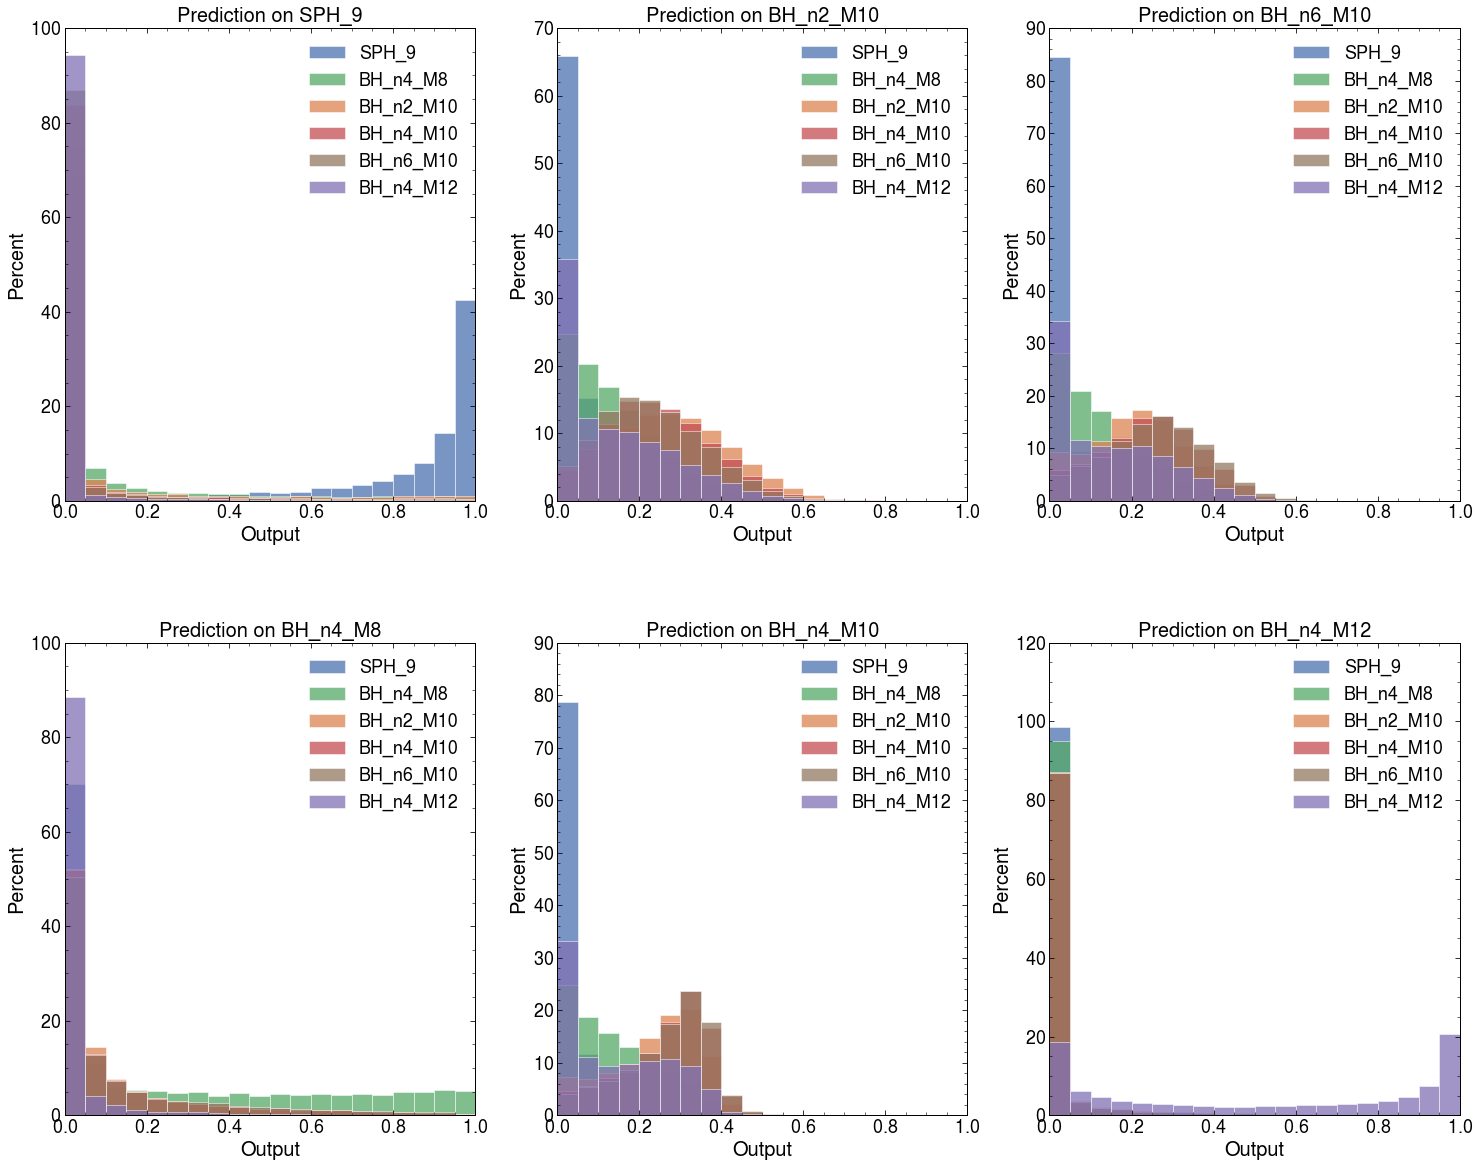

In [45]:
#Print the raw ML outputs before argmax
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25, 20))
plt.subplots_adjust(hspace=0.3)
for i in range(CLASSES):
    for j in range(CLASSES):
        sn.histplot(datasets[i][f"class_{j}"], ax = ax[i%2][i//2], label=f"{PLOT_LABELS[j]}", color=paper_colors[j], binrange=[0, 1], bins=20, 
                    common_norm=False, multiple="layer", fill="False", stat="percent")
    ax[i%2][i//2].set_title(f"Prediction on {PLOT_LABELS[i]}")
    ax[i%2][i//2].legend()
    ax[i%2][i//2].set_xlim(0, 1)
    ax[i%2][i//2].set_xlabel("Output")


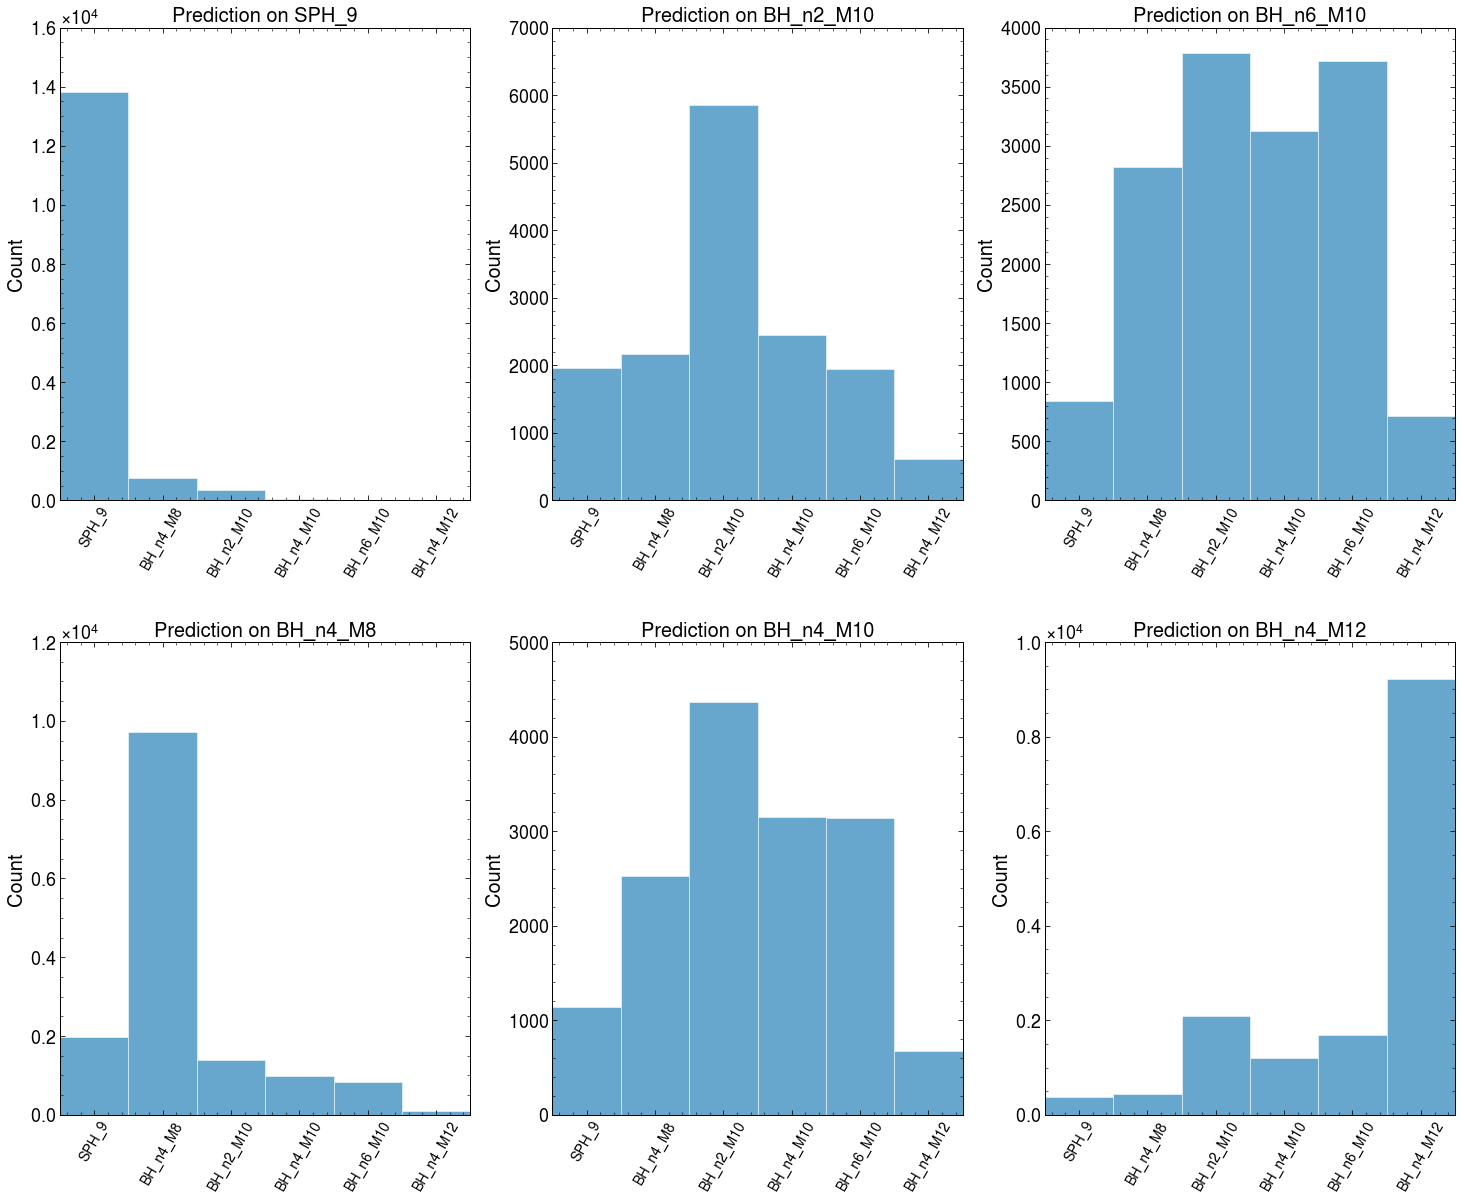

In [46]:
#Print the classifications
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25, 20))
plt.subplots_adjust(hspace=0.3)
for i in range(CLASSES):
    sn.histplot(datasets[i]["Predictions"], binrange=[-0.5, CLASSES-0.5], bins=CLASSES, ax = ax[i%2][i//2])
    ax[i%2][i//2].set_title(f"Prediction on {PLOT_LABELS[i]}")
    ax[i%2][i//2].set_xticks(np.arange(0, CLASSES), PLOT_LABELS, rotation=60, fontsize=14)
    ax[i%2][i//2].set_xlabel("")
    ax[i%2][i//2].set_xlim(-0.5, CLASSES-0.5)


In [47]:
#Do this calculation just once
#Normalized prediction arrays for all datasets [hist1, hist2, ...] where hist1 = [a, b, c... d] with sum(hist1)=1
n_theory = [np.array([((len(theory[theory["Predictions"]==i])/len(theory))) for i in range(CLASSES)]) for theory in datasets]

In [48]:
#Chi2 test
def chi2(theory, data):
    return(np.sum((data-theory)**2/(theory)))

def chi2_method_pearson(theory, data, classes, verbose=False):

    #Number of classified particles in each class
    N_samp = len(data)
    #Number of predicted events for theory
    N_theory = theory*N_samp
    N_data = np.array([len(data[data["Predictions"]==i]) for i in range(classes)])
    #Calculate chi2_value
    chi2_value=chi2(N_theory, N_data)
    #Number of degrees of freedom
    ndof = classes-1
    #Get the p-value from the chi2
    p_value = np.float64((np.float64(1) - stats.chi2.cdf(chi2_value, ndof)))

    if verbose:
        #if p_value < 10**(-10):
        #print("p value: ", p_value)
        print(f"Histogram for data: {N_data}")
        print(f"Histogram theory: {N_theory}")
        print(f"The chi2 value for theory is {chi2_value}. The p-value is {p_value}")
    
    return p_value


In [49]:
data_id = 3
theory_id = 0
print(f"Sending in {PLOT_LABELS[data_id]}, testing against {PLOT_LABELS[theory_id]} theory")

N = 35 #number of events
k = np.random.randint(0, len(bh_2_df)-N)
experiment = datasets[data_id][k:k+N]
print("Detected events")
print(experiment)
print("..... Pearson chi2 test ....")
p2 = chi2_method_pearson(n_theory[theory_id], experiment, CLASSES, verbose=True)

Sending in BH_n4_M10, testing against SPH_9 theory
Detected events
      Truth  Predictions   class_0   class_1   class_2   class_3   class_4   class_5
1422    3.0          2.0  0.057401  0.040412  0.026772  0.258188  0.399278  0.196166
1423    3.0          2.0  0.008426  0.018727  0.034438  0.235459  0.168454  0.008605
1424    3.0          1.0  0.054532  0.333278  0.360992  0.150297  0.372082  0.373289
1425    3.0          2.0  0.063494  0.148392  0.167975  0.278685  0.016313  0.252747
1426    3.0          3.0  0.001103  0.125439  0.243059  0.339842  0.048610  0.293177
...     ...          ...       ...       ...       ...       ...       ...       ...
1452    3.0          1.0  0.033249  0.019254  0.359927  0.253031  0.263520  0.011844
1453    3.0          1.0  0.005183  0.040185  0.370295  0.199214  0.038159  0.040138
1454    3.0          4.0  0.001704  0.178768  0.359661  0.406425  0.313931  0.000785
1455    3.0          2.0  0.002510  0.265754  0.069490  0.215092  0.179925  0.31441

In [50]:
#p-value as a function of number of events
N_list = np.arange(2, N_max, 1) #A list of integers from 2 to N_max

if LOAD:
    #LOAD EXPERIMENT
    p_values_p = np.load(f"../results/chi2/chi_squared_results_{MODEL_NAME}_m_{M}_p_values.npy")
    err_up_values_p = np.load(f"../results/chi2/chi_squared_results_{MODEL_NAME}_m_{M}_norm_err_up_values.npy")
    err_down_values_p = np.load(f"../results/chi2/chi_squared_results_{MODEL_NAME}_m_{M}_norm_err_down_values.npy")

else:
    #RUN EXPERIMENT
    #Generate M random places in the dataset to start sampling
    k_list = [np.random.randint(0, len(datasets[0])-N_max) for i in range(0, M)]

    p_values_p = np.zeros((len(datasets), len(LABELS), len(N_list)))
    err_up_values_p = np.zeros((len(datasets), len(LABELS), len(N_list)))
    err_down_values_p = np.zeros((len(datasets), len(LABELS), len(N_list)))

    for i in tqdm(range(len(datasets))): #Iterate over all types of pseudodata
        for s, sample in enumerate(n_theory): #Iterate over all theories/samples
            for j, n in enumerate(N_list): # Iterate over number of events detected
                experiments = [datasets[i][k:k+n] for k in k_list] #Generate a list of M number of experiments with n events
                results = np.array([chi2_method_pearson(sample, experiment, CLASSES) for experiment in experiments])
                mean = np.average(results, axis=0)
                results_up = results[results>=mean]
                results_down = results[results<mean]
                #print(mean, results_up, results_down)
                if mean > 0:
                    error_up = np.sqrt(((1/len(results_up))*np.sum((results_up - mean)**2)))
                    error_down = np.sqrt(((1/len(results_down))*np.sum((results_down - mean)**2)))
                else:
                    error_up = 0
                    error_down = 0
                p_values_p[i][s][j] = mean
                err_up_values_p[i][s][j] = error_up
                err_down_values_p[i][s][j] = error_down


100%|██████████| 6/6 [1:41:44<00:00, 1017.39s/it]


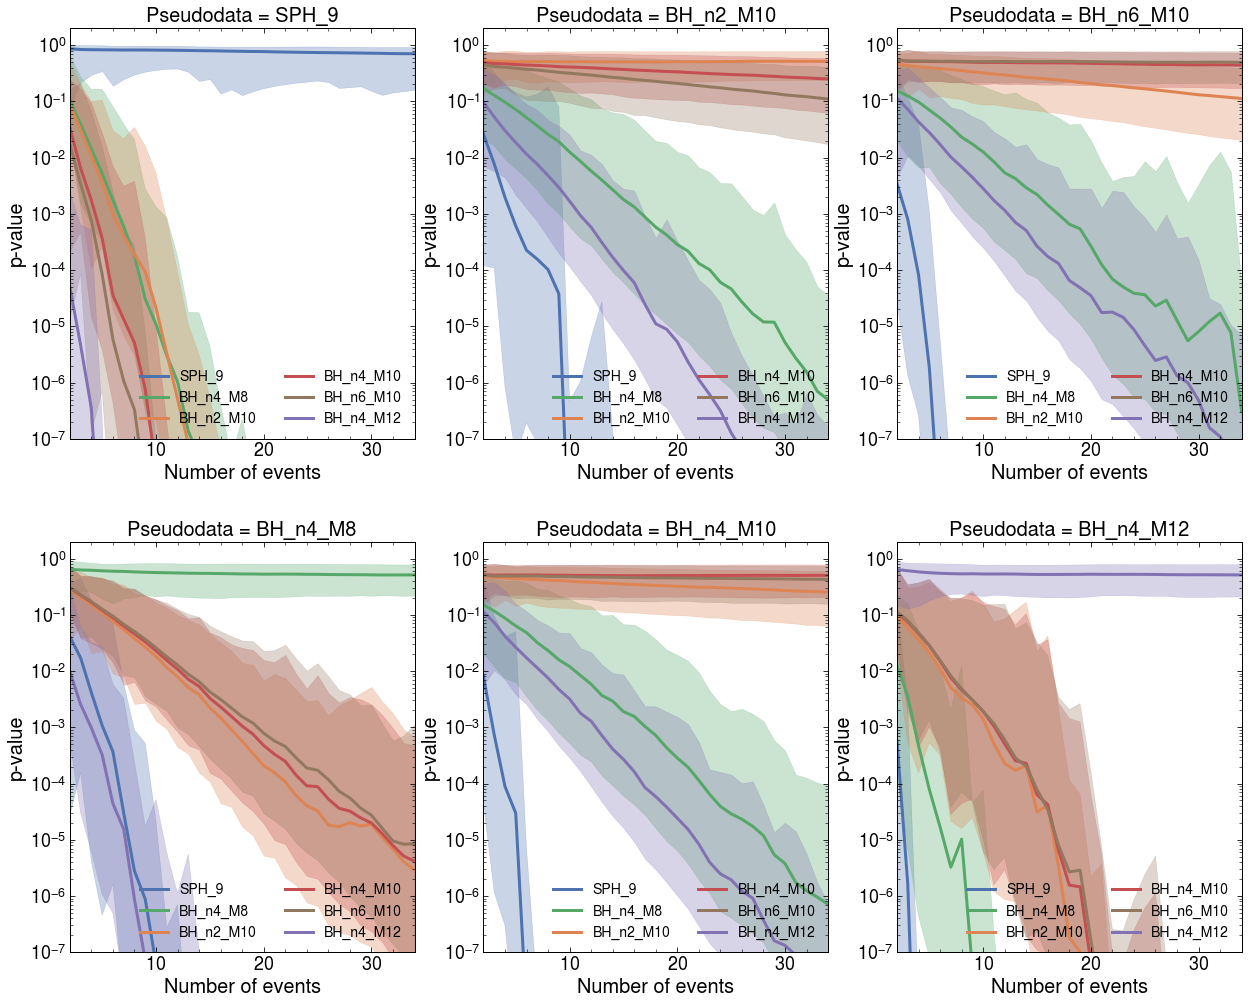

In [51]:

fig, ax = plt.subplots(ncols = 3, nrows=2, figsize=(21, 17))
plt.subplots_adjust(hspace=0.25)
for i in range(len(PLOT_LABELS)): #iterate over pseudodata
    ax[i%2][i//2].set_title(f"Pseudodata = {PLOT_LABELS[i]}")

    for j in range(len(PLOT_LABELS)): #iterate over theories
        ax[i%2][i//2].plot(N_list, p_values_p[i][j], label=PLOT_LABELS[j], color=paper_colors[j], linewidth=3)
        ax[i%2][i//2].fill_between(N_list, p_values_p[i][j] - err_down_values_p[i][j], p_values_p[i][j] + err_up_values_p[i][j], alpha=0.3, color=paper_colors[j])

for axis in ax.reshape(-1):
    axis.set_yscale("log")
    axis.set_xlabel("Number of events")
    axis.set_ylabel("p-value")
    axis.set_xlim(2, N_max-1)
    axis.set_ylim(10**(-7), 2)
    axis.legend(loc=4, fontsize=14, ncol=2)

/home/agrefsru/.conda/envs/matrices/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


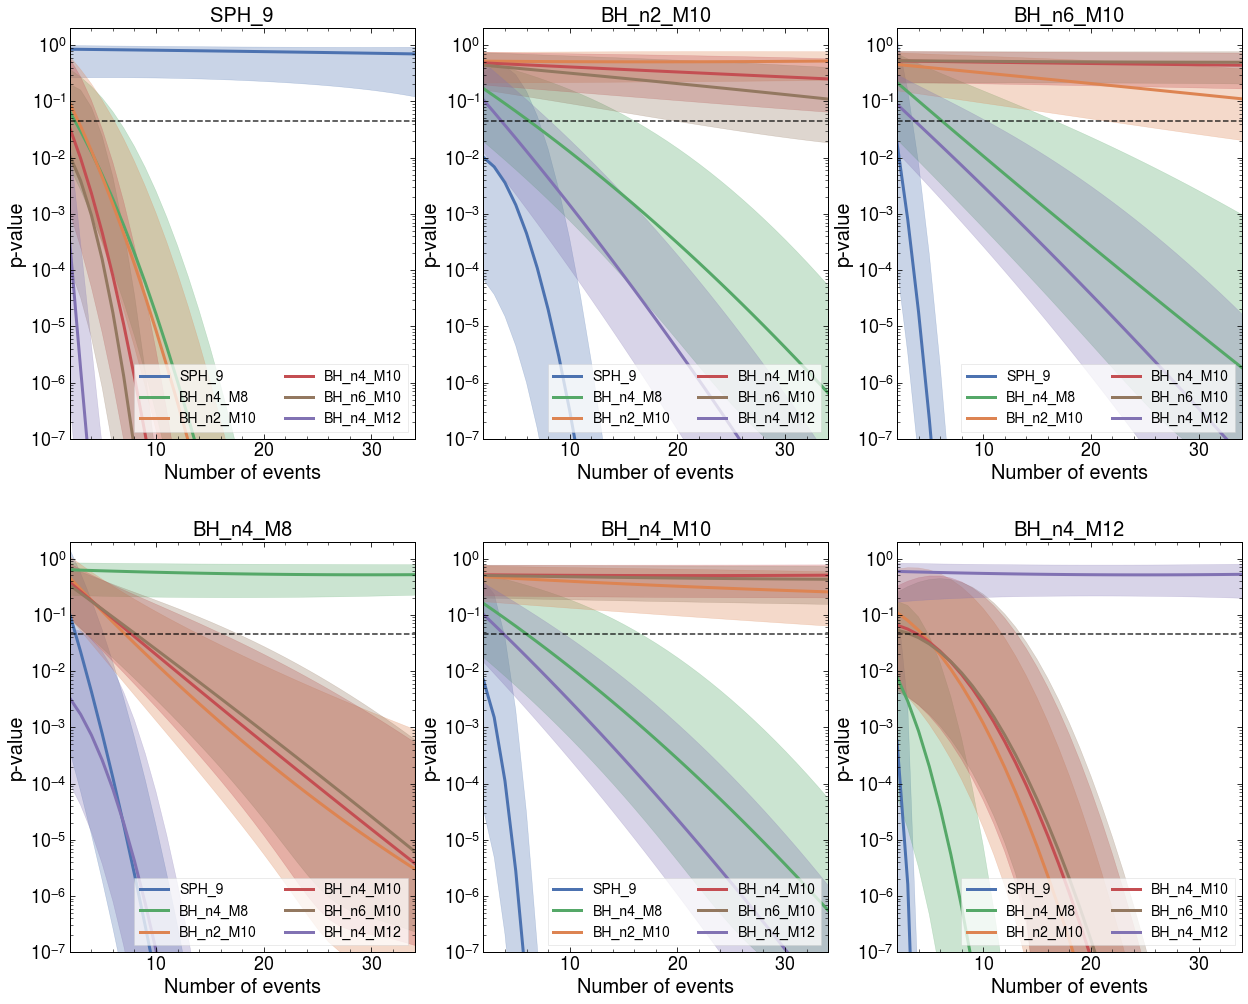

In [52]:
from scipy import optimize
def fit_func(x, a, b, c):
    return (-a*x**2-b*x-c)
 
fig, ax = plt.subplots(ncols = 3, nrows=2, figsize=(21, 17))
plt.subplots_adjust(hspace=0.25)

for i in range(len(PLOT_LABELS)): #iterate over pseudodata
    ax[i%2][i//2].set_title(f"{PLOT_LABELS[i]}")

    for j in range(len(PLOT_LABELS)): #iterate over theories
        y_vals = p_values_p[i][j]
        x_vals = N_list[y_vals>0]
        err_down = err_down_values_p[i][j][y_vals>0]
        err_up = err_up_values_p[i][j][y_vals>0]
        y_vals = y_vals[y_vals>0]

        if len(y_vals)>0:
            
            y_params, y_params_covariance = optimize.curve_fit(fit_func, x_vals, np.log(y_vals), p0=[0, 0, 0], method='dogbox')
            err_down_params, err_down_params_covariance = optimize.curve_fit(fit_func, x_vals, np.log(err_down), p0=[0, 0, 0], method='dogbox')
            err_up_params, err_up_params_covariance = optimize.curve_fit(fit_func, x_vals, np.log(err_up), p0=[0, 0, 0], method='dogbox')

            fit_y_vals = np.exp(fit_func(x_vals, y_params[0], y_params[1], y_params[2]))
            fit_err_down = np.exp(fit_func(x_vals, err_down_params[0], err_down_params[1], err_down_params[2]))
            fit_err_up = np.exp(fit_func(x_vals, err_up_params[0], err_up_params[1], err_up_params[2]))
            
            #print(params)
            #ax[i%2][i//2].scatter(x_vals, y_vals, label=PLOT_LABELS[j], color=paper_colors[j])
            ax[i%2][i//2].plot(x_vals, fit_y_vals, label=PLOT_LABELS[j], color=paper_colors[j], linewidth=3)
            ax[i%2][i//2].fill_between(x_vals, fit_y_vals - fit_err_down, fit_y_vals + fit_err_up, alpha=0.3, color=paper_colors[j])
        
        else:
            ax[i%2][i//2].scatter(x_vals, y_vals, label=PLOT_LABELS[j], color=paper_colors[j])

for axis in ax.reshape(-1):
    axis.set_yscale("log")
    axis.set_xlabel("Number of events")
    axis.set_ylabel("p-value")
    axis.set_xlim(2, N_max-1)
    axis.set_ylim(10**(-7), 2)
    axis.legend(loc=4, fontsize=14, ncol=2, frameon=True)
    axis.plot(x_vals, [0.0455]*len(x_vals), color="black", linestyle="--", alpha=0.8)

In [53]:
#Save results as text file
if not LOAD:
    np.set_printoptions(threshold=sys.maxsize)
    with open(f"../results/chi_squared_results_{MODEL_NAME}_M_{M}.txt", "w") as f:
        f.write(f"Testing model {MODEL_NAME}. \n")
        f.write(f"Number of events in data: \n")
        f.write(f"{len(sph_df)} \n")
        f.write(f"Classes in data: \n")
        f.write(f"{CLASSES} \n")
        f.write(f"Number of events detected: \n")
        f.write(f"{N_list} \n")
        f.write(f"Number of samples for each n number of events: {M} \n")

        f.write(f"p_values: \n")
        f.write(f"{p_values_p} \n")
        f.write(f"Error up: \n")
        f.write(f"{err_up_values_p} \n")
        f.write(f"Error down: \n")
        f.write(f"{err_down_values_p} \n")
        f.close()


In [54]:
#Save results
if not LOAD:
    np.save(f"../results/chi2/chi_squared_results_{MODEL_NAME}_m_{M}_p_values.npy", p_values_p)
    np.save(f"../results/chi2/chi_squared_results_{MODEL_NAME}_m_{M}_up_values.npy", err_up_values_p)
    np.save(f"../results/chi2/chi_squared_results_{MODEL_NAME}_m_{M}_down_values.npy", err_down_values_p)